In this tutorial, we walk you through an application of PySCN to analyze mouse embryonic stem cells (mESCs) undergoing differentiation as embryoid bodies. We first train and assess a classifier with scRNAseq of gastrula-stage embryos. Then, we use this classifier to predict the cell type of the embryoid body cells. In the Categorization section below, we describe an approach to categorizing the predictions based on confidence in their accuracy and based on the relatedness of the predicted cell types predicted. We end this tutorial by showing how this categorization can help to identify signatures that distinguish *in vitro* cells from their *in vivo* counterparts.

### Data

#### Training data
The training data is a subset of the mouse gastrulation atlas described in [Pijuan-Sala et al Nature 2019](https://www.nature.com/articles/s41586-019-0933-9). We have reduced the size of this dataset to make running this tutorial more accessible. We have also re-annotated the cell lineages based on recent spatial transcriptomics studies of mouse gastrulation (see [Lohoff et al 2021](https://www.nature.com/articles/s41587-021-01006-2) and [Kumar et al 2023](https://www.nature.com/articles/s41588-023-01435-6)).

You can download the training data from [here](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/0.1.4/adPijuan_small.h5ad)
- 17,480 cells
- 29,329 genes
- cell type labels in `.obs['ct1']`

#### Query data set

The query data comes from one of our the lab's first papers [Spangler et al 2018](https://www.sciencedirect.com/science/article/pii/S1873506118301909). 

<figure>
    <img src="./img/eb_diagram.png" alt="Embryoid body protocol" width="600">
    <figcaption>Protocol for making mouse embryoid bodies. Data here is only from day 4.</figcaption>
</figure>

Embryoid body day 4
  - [download h5ad here](https://cnobjects.s3.amazonaws.com/singleCellNet/pySCN/resources/notebook_data/adata_Spangler_EB_day4_clean_raw_010225.h5ad)


### Start up

Import requisite packages and load the data.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import pySingleCellNet as cn

In [2]:
adRef = sc.read_h5ad("adPijuan_small.h5ad")
adQuery = sc.read_h5ad("adata_Spangler_EB_day4_clean_raw_010225.h5ad")

Limit to shared genes

In [3]:
cn.ut.limit_anndata_to_common_genes([adRef, adQuery])

Split the reference data into training and held out data.

In [4]:
n_cells = 500
groupby = 'ct1'
stratify_by = 'stage'
tids, vids = cn.ut.split_adata_indices(adRef, n_cells, groupby=groupby, cellid=None, strata_col=stratify_by)
adTrain = adRef[tids].copy()
adHO = adRef[vids].copy()

Prepare the training data.

In [5]:
adTrain.layers['counts'] = adTrain.X.copy()
sc.pp.normalize_total(adTrain)
sc.pp.log1p(adTrain)
sc.pp.highly_variable_genes(adTrain, n_top_genes=2000, flavor='seurat_v3', layer='counts')
sc.tl.pca(adTrain, mask_var='highly_variable')

Train the classifier.

In [6]:
n_rand = n_cells
nTopGenes = 30
nTopGenePairs = 40
n_comps = 30

clf = cn.tl.train_classifier(adTrain, groupby, nRand = n_rand, nTopGenes = nTopGenes, nTopGenePairs = nTopGenePairs, n_comps = n_comps)

Training classifier |████████████████████████████████████████| 5/5 [100%] in 32.5s (0.15/s) 


Apply classifier to held out data

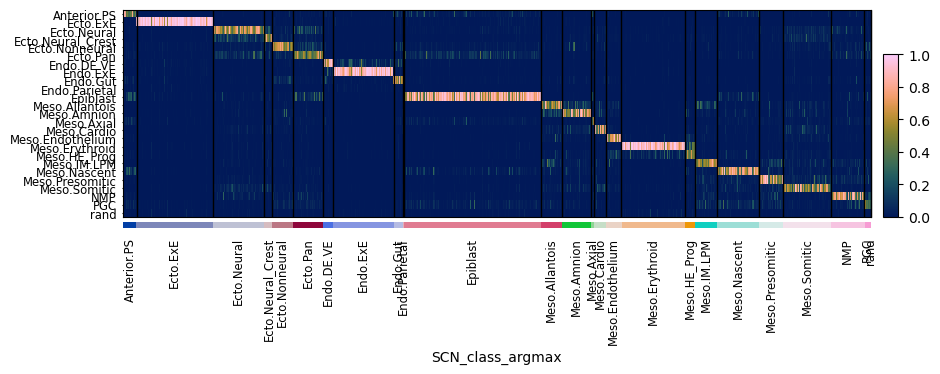

In [7]:
obs_pred="SCN_class_argmax"
cn.tl.classify_anndata(adHO, clf, nrand = 0)
cn.pl.heatmap_scores(adHO, groupby='SCN_class_argmax')

Assess performance

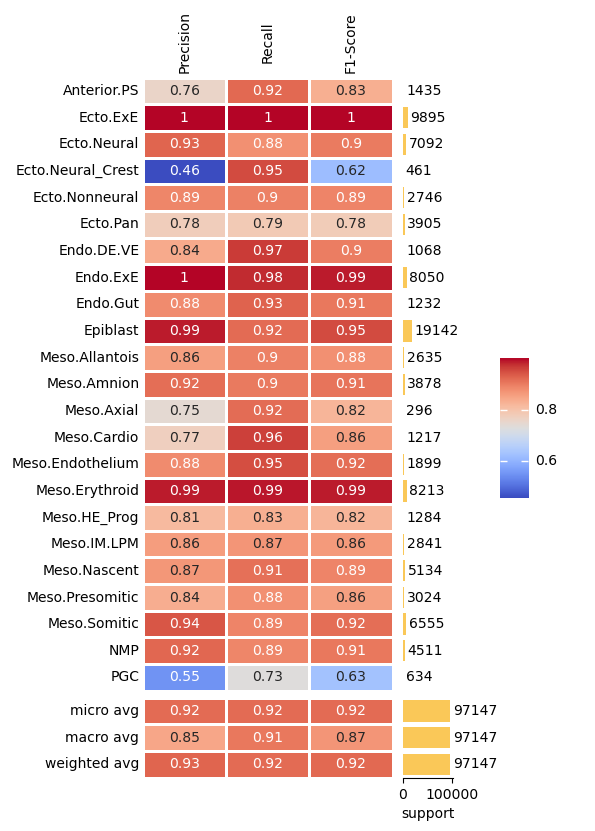

In [8]:
c_report = cn.tl.create_classifier_report(adHO, ground_truth=groupby, prediction=obs_pred)
cn.pl.heatmap_classifier_report(c_report)
plt.show()

Classify the embryoid body cells.

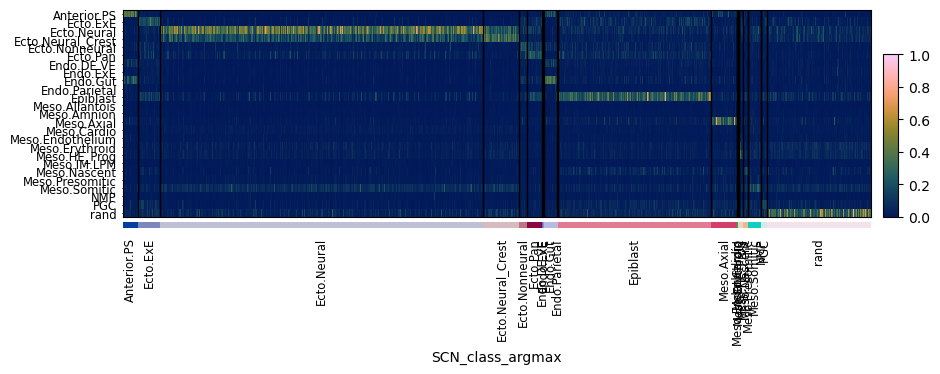

In [9]:
cn.tl.classify_anndata(adQuery, clf)
cn.pl.heatmap_scores(adQuery, groupby='SCN_class_argmax')

### Categorization

By looking at the heatmap above, you can see that there are some cases where even a maximum SCN_score for a cell is relatively low. There are several reasons that this might occur. For example, a cell might receive high scores for more than one cell type because it is in a developmental intermediate state. Other possible classification results are depicted below.

<figure>
    <img src="./img/categories.jpg" alt="Categorization" width="7500">
    <figcaption>How PySCN assigns categories.</figcaption>
</figure>

To apply these category labels, we need to select SCN_score thresholds. Below, we will determine cell-type specific SCN_score thresholds to empirically categorize classification predictions. The thresholds are determined as the 5th percentile of SCN_score of known true positives for each cell type. Then we will assign categorization labels as indicated in the figure above and as listed below:

- If SCN_score of exactly one cell type exceeds threshold: "Singular"
- If SCN_score of no cell types (including 'rand') exceed threshold: "None"
- If  SCN_score of more than one cell type exceeds threshold:
  * If all pairs of high-scoring cell types are within `k` edges in the provided graph: "Intermediate"
  * Otherwise: "Hybrid"
- If predicted cell type is 'rand': "Rand"

This approach ensures that when applied to the reference data, the categorization process should result in 95% of cells receiving a category of 'Singular', 'Intermediate', 'Hybrid' (or 'rand' for rand cells). 

Compute the cell-type specific thresholds

In [10]:
tThrs_val_05_HO = cn.tl.comp_ct_thresh(adHO, 0.05)

Distingiushing hybrids from intermediates requires the user to provided cell typ relationship information in the form of a graph. This can come from prior knowledge of ontogeny, or it can be  inferred from transcriptional similarity in the reference data. In the next function call, we infer a relatenedness graph from the reference data.

In [11]:
rela_graph = cn.tl.paga_connectivities_to_igraph(adTrain, threshold = 0.3, n_comps = n_comps, group_key = groupby)

Finally, we will categorize the classification results. Note that a manually created graph can be used in place of that returned by `cn.tl.paga_connectivities_to_igraph`

In [12]:
cn.tl.categorize_classification(adQuery, tThrs_val_05_HO, rela_graph)

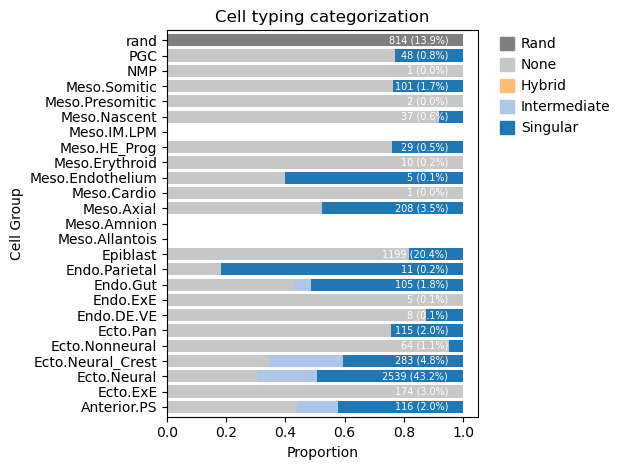

In [13]:
cn.pl.stackedbar_categories(adQuery, class_col_name='SCN_class_argmax', show_pct_total=True)
plt.show()

The x-axis is the proporition of query cells with a given SCN_class_argmax fall into each category. The numbers indicate the total (and percent of total) of that SCN_class_argmax in the anQuery.

### Compare Singular vs None

What distinguishes cells that have high classification score from those that have low scores? Pre-process the query data.

In [14]:
adComp = adQuery.copy()
sc.pp.filter_genes(adComp, min_cells = 10)
adComp.layers["counts"] = adComp.X.copy()
sc.pp.normalize_total(adComp)
sc.pp.log1p(adComp)

Now create a new .obs column that combines the argmax label prediction with the categorization. Then, remove groups of size < 50 cells.

Filtering AnnData object based on group sizes in 'SCN_combined_max':
 - Total groups: 43
 - Groups retained (≥ 75 cells): 13
 - Groups excluded (< 75 cells): 30
Filtered AnnData object contains 5304 cells from 13 groups.


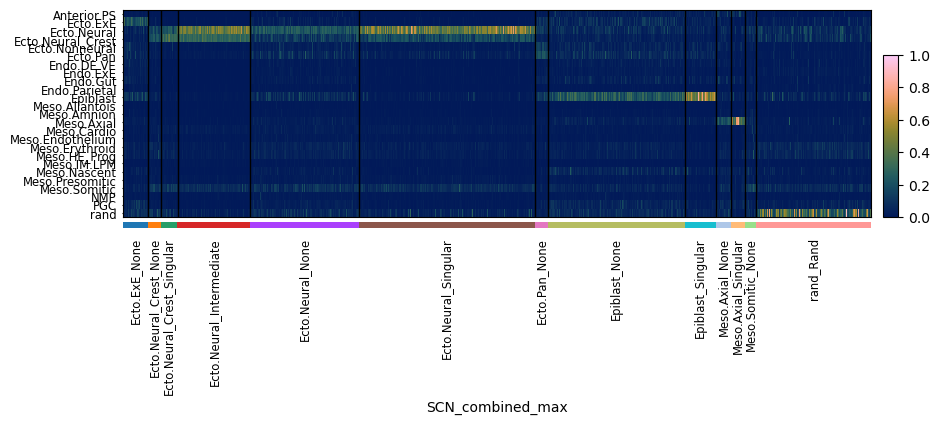

In [15]:
new_col = "SCN_combined_max"
adComp.obs[new_col] = adComp.obs["SCN_class_argmax"].astype(str) + "_" + adComp.obs["SCN_class_type"].astype(str)
adComp.obs[new_col] = adComp.obs[new_col].astype(str).astype("category")
adx = cn.ut.filter_adata_by_group_size(adComp, new_col, 75)
cn.pl.heatmap_scores(adx, groupby=new_col)

We can see that Ecto.Neural, Epiblast, and Meso.Axial are the only cell types in which we have at least 75 cells in both the None and Singular categories. Let's compare those directly to each other.

In [16]:
cellgrps = ["Ecto.Neural", "Epiblast", "Meso.Axial"]
cats_to_comp = ["Singular", "None"]
deg_res = cn.tl.deg(adx, sample_obsvals=cats_to_comp, limitto_obsvals=cellgrps, cellgrp_obsname = 'SCN_class_argmax',groupby_obsname='SCN_class_type',ncells_per_sample = 10, test_name='t-test', mask_var=None)

cell group: Ecto.Neural
cell group: Epiblast
cell group: Meso.Axial


One plausible difference between the 'None' and 'Singular' is simply that the 'None' have not upregulated lineage specific genes sufficiently. To test this, we will perform GSEA using the lineage-enriched genes that are stored during the training process.

In [17]:
genesets = clf['diffExpGenes']
gsname = "lineage_specific"
gsea_res = cn.tl.gsea_on_deg(deg_res['geneTab_dict'], gsname, genesets = genesets, permutation_num = 1e3)

2025-09-15 08:43:48,356 [WARNING] Duplicated values found in preranked stats: 1.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-15 08:43:49,073 [WARNING] Duplicated values found in preranked stats: 2.83% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-15 08:43:49,781 [WARNING] Duplicated values found in preranked stats: 17.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


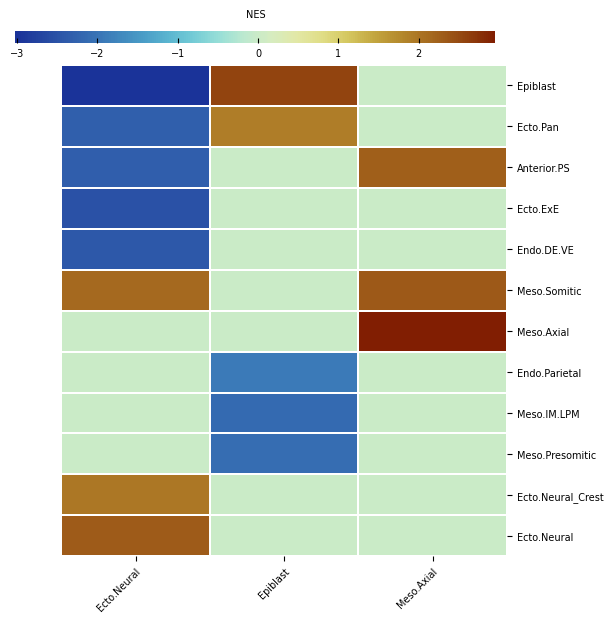

In [18]:
gres_trim = cn.tl.collect_gsea_results_from_dict(gsea_res, .01)
cn.pl.heatmap_gsea(gres_trim,clean_signatures = True, clean_cells=False, col_cluster=True, row_cluster=True)

This heatmap shows the normalized enrichment score (NES) of comparing 'Singular' vs 'None' cells that share the same predicted label. Columns are the groups of cells. Rows are the gene signatures tested for enrichment. In this case, we have used the gene signatures of each cell type from the reference embryo data. In the case of cells labeled as 'Epiblast', the heatmap tells us that 'Singular' cells are enriched in the Epiblast signature, whereas the 'None' epiblast cells are enriched in Meso.IM.LPM and Meso.Allantois signatures.

We can also look at the enrichment of any other gene sets, for example, GOBP

In [19]:
genesets = cn.ut.read_gmt("m5.go.bp.v2023.2.Mm.symbols.gmt")
gsname = "GOBP"
gsea_res = cn.tl.gsea_on_deg(deg_res['geneTab_dict'], gsname, genesets = genesets, permutation_num = 1e3)

2025-09-15 08:43:50,799 [WARNING] Duplicated values found in preranked stats: 1.34% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-15 08:44:46,991 [WARNING] Duplicated values found in preranked stats: 2.83% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-09-15 08:45:42,360 [WARNING] Duplicated values found in preranked stats: 17.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


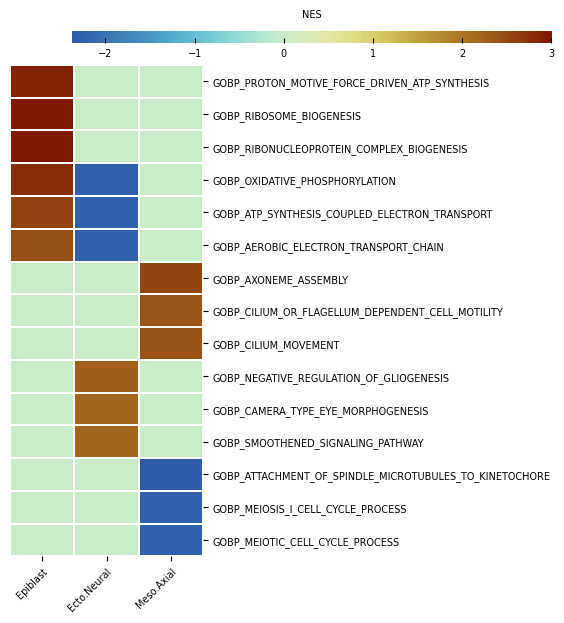

In [20]:
gres_trim = cn.tl.collect_gsea_results_from_dict(gsea_res, .01)
cn.pl.heatmap_gsea(gres_trim,clean_signatures = True, clean_cells=False, col_cluster=True, row_cluster=True)

Let's end by embedding the query data based on a combination of the SCN_class_scores and PCs.

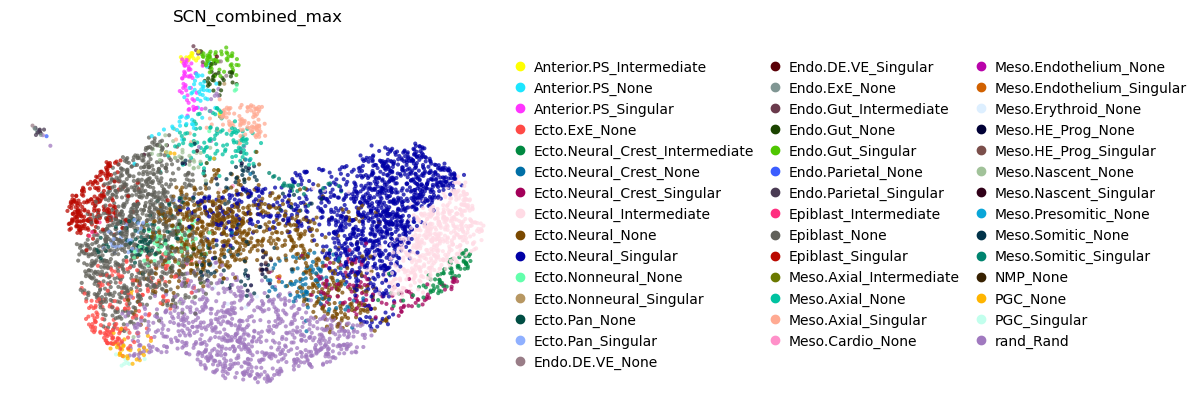

In [21]:
sc.pp.highly_variable_genes(adComp, n_top_genes=2000, flavor='seurat_v3', layer="counts")
sc.tl.pca(adComp, mask_var='highly_variable')

def_npcs = 30
def_nneigh = 10

sc.pp.neighbors(adComp, n_neighbors = def_nneigh,  n_pcs = def_npcs)
sc.pp.neighbors(adComp, n_neighbors = def_nneigh,  use_rep = 'SCN_score', key_added='SCN_score_NN')

cn.ut.generate_joint_graph(adComp, connectivity_keys = ["connectivities", "SCN_score_NN_connectivities"], weights=[0.25, 0.75], output_key='jointNN')
sc.tl.umap(adComp,  neighbors_key='jointNN')
sc.pl.umap(adComp, color=['SCN_combined_max'], size=35, alpha=.75,frameon=False)

